In [45]:
# Julia version code
"""
nonnegative linear regression 
"""

using LinearAlgebra, BenchmarkTools, Distributions, Plots
const MultivariateDistribution{S<:ValueSupport} = Distribution{Multivariate,S}
const DiscreteMultivariateDistribution   = Distribution{Multivariate, Discrete}
const ContinuousMultivariateDistribution = Distribution{Multivariate, Continuous}

function compute_scaling(A)
    scaling_vector = -1 ./sum(abs2.(A),dims=1) # scaling_vector[j] = -1/||A_{:j}||^2
    return scaling_vector
end

function init_all(epsilon, m, n, A)
    ktotal = Int(ceil(n/sqrt(epsilon))) #note that this is just an approx ktotal
    
    akm = 1/n #a_1
    Akm = 1/n #A_1
    ak = 1/n^2 #a_2
    Ak = (1+n)/n^2 #A_2
    
    scaling_vector = compute_scaling(A) 
    
    randomseed=rand(Multinomial(1, ones(n)/n),1)
    jk = findall(vec(randomseed.==1))[1] #find the index at which we have a "1"
    
    v = zeros(n) # vector used to construct x
    v[jk] = -1 
    xkm = zeros(n) #x_1 
    xkm[jk]=-1*scaling_vector[jk] #xkm[jk] = 1/||A_{:jk}||^2
    
    ykm = A*xkm # ykm = y_1 
    xtildek = deepcopy(xkm) #we need "copy()" or "deepcopy()" so that modifying xtildek doesn't modify xkm
    ybar = (n+1) * ykm # ybar = ybar_1
    
    return ybar, ykm, xtildek, ktotal, ak, akm, Ak, Akm, v, xkm, scaling_vector
end

function update_v(jk, A, ybar, v, ak) 
    v[jk]+= n*ak*(dot(A[:,jk],ybar) - 1) # ybar = ybar_{k-1}
    # no need to return v because the value in memory is changed
end

function update_x(v, jk, xkm, scaling) 
    x = deepcopy(xkm)
    x[jk] = min(max(scaling*v[jk], 0),-scaling) # n has appeared in v
    return x      
end

function update_y(n, ak, Ak, Akm, x, xkm, xtildek, A)
    xtildek .= (Akm/Ak)*xtildek+(n*ak/Ak)*x-((n-1)*ak/Ak)*xkm 
    # we crucially need .= here for xtildek to be updated,
    # since we are passing in the memory and changing there. 
    y = A*xtildek
    return y
end

function update_ak_Ak(Ak, Akm, ak, akm, n) 
    akm = ak
    ak = min(n*ak/(n-1),sqrt(Ak)/(2*n))
    Akm = Ak
    Ak = Ak+ ak
    return Ak, Akm, ak, akm # need to return because they are scalars, not arrays
end

function update_ybar(y, ykm, ak, akm)
    ybar = y + (akm/ak)*(y - ykm)
    return ybar 
end

function remove_col1(A,b)
    s=A'*b # n*1 
    B=A[:,vec(s.>0)] # m*b matrix where b is smaller than n
    s=s[vec(s.>0)] # s is b*1 in dimensions
    A .= B./s'
    return B, s
end

remove_col1 (generic function with 1 method)

-4.8703489168903715f = Plot{Plots.GRBackend() n=1}


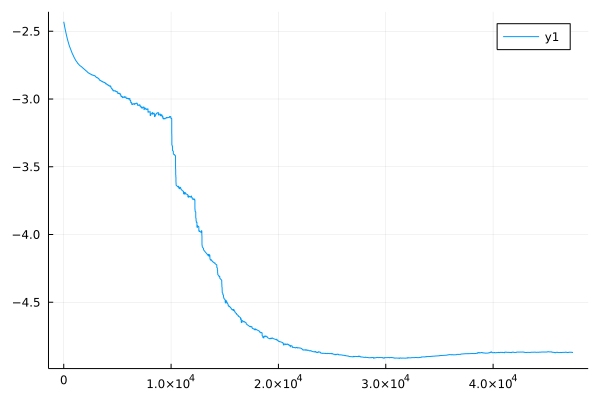

In [69]:
# Main code
epsilon = 0.001 
n = 1500 # variable dimension 
m = 200 # Number of data points

# b can also be random and negative. m<<n.

b=rand(m,1)-repeat([0.3],m,1)
A=rand(m,n)

(B,s)=remove_col1(A,b) #A is modified in memory, therefore not returned

(m,n)=size(A) # Redefine the size number n and m to prevent triviality.

(ybar, ykm, xtildek, ktotal, ak, akm, Ak, Akm, v, xkm, scaling_vector) = init_all(epsilon, m, n, A)

xinit = deepcopy(xtildek)

our_result = zeros(ktotal) #we store the objective value in our_result
our_result[1] = norm(A*xtildek)^2/2-sum(xtildek)

for k in 2:ktotal 
        # sample jk from multinomial distribution
        randomseed=rand(Multinomial(1, ones(n)/n),1)
        jk = findall(vec(randomseed.==1))[1] # 
    
        # update v (this is the randomized part in the update of x)
        update_v(jk, A, ybar, v, ak) 
        
        # update x
        x = update_x(v, jk, xkm, scaling_vector[jk])
        
        # Update y and xtildek
        y = update_y(n, ak, Ak, Akm, x, xkm, xtildek, A)
    
        #update ak, Ak, Akm, akm 
        (Ak, Akm, ak, akm) = update_ak_Ak(Ak, Akm, ak, akm, n)
    
        #update ybar 
        ybar = update_ybar(y, ykm, ak, akm)
     
        # update xkm 
        xkm = deepcopy(x)
        
        our_result[k] = norm(A*xtildek)^2/2-sum(xtildek)
end

our_solution = deepcopy(xtildek)
print(norm(A*our_solution)^2/2-sum(our_solution))

f = plot(our_result)
@show f

In [70]:
# using https://jump.dev/Convex.jl/stable/
# import Pkg; Pkg.add("Convex"); Pkg.add("SCS") to install
using Convex, SCS
x = Variable(n)
problem = minimize(0.5*sumsquares(A * x)-sum(x), [x >= 0])
solve!(problem, () -> SCS.Optimizer(verbose=false))
problem.optval

-5.251858796007383

-5.080483778892796